# Importar as bibliotecas necessárias

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import Dataset, DatasetDict
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report


2025-02-03 11:59:09.822586: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738594749.838269  495286 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738594749.843067  495286 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-03 11:59:09.859473: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Carregar base de dados

In [2]:
# Carregar o CSV
df = pd.read_csv("/home/fernando/Disciplina_NLP/Atv_4/data/review_polarity.csv") # Substituir pelo caminho correto

# Exibir as primeiras linhas para verificar o formato
print(df.head())

         file_name                                               text class
0  cv145_12239.txt  it was once said that in order to truly enjoy ...   neg
1  cv745_14009.txt  conventional wisdom among collectibles retaile...   neg
2  cv376_20883.txt  robin williams has the rarest of gifts : the a...   neg
3  cv109_22599.txt  nearly every film tim burton has directed has ...   neg
4  cv494_18689.txt  you know , i never really wondered what the ta...   neg


# Dividir a base de dados

In [3]:
# Garantir que o dataframe tenha as colunas esperadas
df = df.rename(columns={"text": "text", "class": "label"})  # Ajuste conforme necessário

# Converter para Dataset do Hugging Face
dataset = Dataset.from_pandas(df)

# Divisão entre treino (70%), validação (10%) e teste (20%)
train_test_split = dataset.train_test_split(test_size=0.3)
test_valid_split = train_test_split["test"].train_test_split(test_size=2/3)

dataset_final = DatasetDict({
    "train": train_test_split["train"],
    "validation": test_valid_split["train"],
    "test": test_valid_split["test"]
})

# Verificar o número de exemplos em cada conjunto
for split in dataset_final:
    print(f"{split}: {len(dataset_final[split])} exemplos")



train: 1400 exemplos
validation: 200 exemplos
test: 400 exemplos


In [4]:
for split in ["train", "validation", "test"]:
    print(f"\n🔹 Exemplos do conjunto {split.upper()}:\n")
    for i in range(5):
        print(f"Texto: {dataset_final[split][i]['text']}")
        print(f"Label: {dataset_final[split][i]['label']}\n")



🔹 Exemplos do conjunto TRAIN:

Texto: if beavis and butthead had a favorite movie , from dusk till dawn would probably be it . scripted by quentin tarantino and directed by robert rodriguez ( desperado ) , the movie panders to the very worst in sex and violence -- and is incredibly fun to watch . it starts off as a pulp fiction-type crime story , with criminal brothers george clooney and tarantino robbing a convenience store . because this is a tarantino movie , however , it's not just a case of pull the gun and take the loot , it's a case of a hole being shot through someone's hand , a man on fire jumping out behind the counter and the entire store blowing up as they drive away . the opening scene sets the tone for the rest of the movie -- everything overdone and nothing as it seems . clooney and tarantino bring a hostage to the motel and then hijack an rv with a family in it . harvey keitel plays the backslidden ex-preacher and juliette lewis his daughter , whom registered sex-perve

In [5]:
# Exibir rótulos únicos antes da conversão
print(set(dataset_final["train"]["label"]))
print(set(dataset_final["validation"]["label"]))
print(set(dataset_final["test"]["label"]))


{'neg', 'pos'}
{'neg', 'pos'}
{'neg', 'pos'}


In [6]:
def fix_labels(example):
    label_map = {"neg": 0, "pos": 1}  # Mapeia os rótulos para números
    example["label"] = label_map.get(example["label"], -1)  # Define -1 para valores desconhecidos
    return example

dataset_final = dataset_final.map(fix_labels)


Map:   0%|          | 0/1400 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

# Tokenizar os textos

In [7]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Função para tokenizar
def tokenize_function(examples):
    return tokenizer(
        examples["text"], 
        padding=True,  # Garante que todos os textos tenham o mesmo tamanho
        truncation=True,  # Corta textos muito longos para evitar erro
        max_length=512  # Define o tamanho máximo para os tokens
    )

# Aplicar a tokenização
tokenized_datasets = dataset_final.map(tokenize_function, batched=True)

# Visualizar tokens de um exemplo
example_text = dataset_final["train"][0]["text"]
tokens = tokenizer.tokenize(example_text)
print("Tokens de um documento:")
print(tokens)


Map:   0%|          | 0/1400 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Tokens de um documento:
['if', 'bea', '##vis', 'and', 'butt', '##head', 'had', 'a', 'favorite', 'movie', ',', 'from', 'dusk', 'till', 'dawn', 'would', 'probably', 'be', 'it', '.', 'scripted', 'by', 'quentin', 'tara', '##ntino', 'and', 'directed', 'by', 'robert', 'rodriguez', '(', 'des', '##per', '##ado', ')', ',', 'the', 'movie', 'pan', '##ders', 'to', 'the', 'very', 'worst', 'in', 'sex', 'and', 'violence', '-', '-', 'and', 'is', 'incredibly', 'fun', 'to', 'watch', '.', 'it', 'starts', 'off', 'as', 'a', 'pulp', 'fiction', '-', 'type', 'crime', 'story', ',', 'with', 'criminal', 'brothers', 'george', 'cl', '##oon', '##ey', 'and', 'tara', '##ntino', 'robb', '##ing', 'a', 'convenience', 'store', '.', 'because', 'this', 'is', 'a', 'tara', '##ntino', 'movie', ',', 'however', ',', 'it', "'", 's', 'not', 'just', 'a', 'case', 'of', 'pull', 'the', 'gun', 'and', 'take', 'the', 'lo', '##ot', ',', 'it', "'", 's', 'a', 'case', 'of', 'a', 'hole', 'being', 'shot', 'through', 'someone', "'", 's', 'hand

# Treinar o modelo BERT

In [8]:
# Carregar modelo BERT pré-treinado para classificação binária
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# Configurar os parâmetros de treinamento
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs"
)

# Função de avaliação com métricas
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    acc = accuracy_score(labels, preds)
    f1_micro = f1_score(labels, preds, average="micro")
    f1_macro = f1_score(labels, preds, average="macro")
    return {"accuracy": acc, "f1_micro": f1_micro, "f1_macro": f1_macro}

# Criar Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Iniciar o treinamento
trainer.train()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/fernando/anaconda3/lib/python3.12/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_495286/511587110.py:27: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Micro,F1 Macro
1,No log,0.345659,0.860000,0.860000,0.859986
2,No log,0.335681,0.885000,0.885000,0.884928
3,0.326600,0.438128,0.905000,0.905000,0.904998


TrainOutput(global_step=525, training_loss=0.31547059013730006, metrics={'train_runtime': 506.8263, 'train_samples_per_second': 8.287, 'train_steps_per_second': 1.036, 'total_flos': 1105066432512000.0, 'train_loss': 0.31547059013730006, 'epoch': 3.0})

# Avaliação no conjunto de teste + Relatório Detalhado

Acurácia: 0.8825
F1-score (Micro): 0.8825
F1-score (Macro): 0.8825


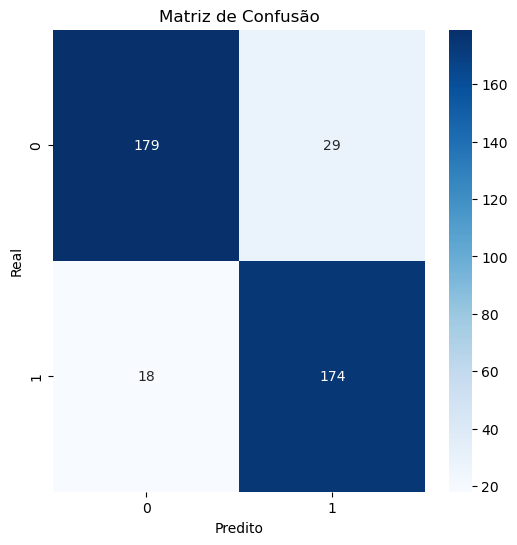

Relatório de Classificação:

              precision    recall  f1-score   support

    Negativo       0.91      0.86      0.88       208
    Positivo       0.86      0.91      0.88       192

    accuracy                           0.88       400
   macro avg       0.88      0.88      0.88       400
weighted avg       0.88      0.88      0.88       400



In [9]:
# Fazer previsões
predictions = trainer.predict(tokenized_datasets["test"])
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

# Calcular métricas principais
acc = accuracy_score(labels, preds)
f1_micro = f1_score(labels, preds, average="micro")
f1_macro = f1_score(labels, preds, average="macro")
conf_matrix = confusion_matrix(labels, preds)

# Exibir métricas principais
print(f"Acurácia: {acc:.4f}")
print(f"F1-score (Micro): {f1_micro:.4f}")
print(f"F1-score (Macro): {f1_macro:.4f}")

# Exibir matriz de confusão
plt.figure(figsize=(6,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.show()

# **Relatório detalhado das métricas**
print("Relatório de Classificação:\n")
print(classification_report(labels, preds, target_names=["Negativo", "Positivo"]))
